# Mass evacuation gymnasium tutorial

This tutorial demonstrates how to use the gym_mass_evacuation python package to study a multi-domain response to a mass evacuation. 

In [74]:
# import packages
import gymnasium as gym
import numpy as np
import pandas as pd
import copy
import math
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

Next, import two modules from the gym_mass_evacuation package. The first module, mass_evacuation, contains the mass evacuation gymnasium environment. The second module, mass_evacuation_policy, contians a set of benchmark policy function approximations as described in Rempel (2024).

In [75]:
from gym_mass_evacuation.mass_evacuation import MassEvacuation
from gym_mass_evacuation.mass_evacuation_policy import MassEvacuationPolicy

## Setting up the initial state, environment, and decision policies

First, we define the seed used in the random number generator. This seed, which is the same as used in Rempel (2024) (although not explicitly reported), is used to initiate a random number generator. This single generator is used to: (i) generate the initial transition times of individuals between medical conditions; (ii) generate new transition times when an individual is loaded on or off the ship; and (iii) generate random numbers to determine if an individual has transitioned between medical conditions each time the transition function is executed. Note: A separate random number generator is used for the benchmark policies, but a seed is not provided in this instance.

Second, we define the initial state $S_0$. This is the same initial state used in Rempel (2024), as listed in Table 5. However, note the addition of the initial helicopter arrival time and initial ship arrival time. In Rempel (2024) these were considered as separate parameters that were input to the simulation; they are now integrated into the initial state in order to provide a clearner interface.

In [76]:
# set the environment's seed and initial state that was used in Rempel (2024)
# Set the seed that was used in Rempel (2024)
rempel_2024_seed = 20180529

# Set the initial state
rempel_2024_initial_state = {
            'm_e' : {'white' : 120, 'green' : 48, 'yellow' : 8, 'red' : 1.5},
            'm_s' : {'green' : 48, 'yellow' : 72, 'red' : 120},
            'c_h' : 10,
            'c_s' : 50,
            'delta_h' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'delta_s' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'eta_h' : 3,
            'eta_sl' : 1,
            'eta_su' : 24,
            'tau_k' : 0,
            'e_k' : 0,
            'rho_e_k' : {'white' : 0, 'green' : 475, 'yellow' : 20, 'red' : 5},
            'rho_s_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
            'initial_helo_arrival' : [48],
            'initial_ship_arrival' : [0]
        }

Next, we create the gymnasium environment and a benchmark policy object. The gymnasium environment requries three parameters: the initial state, the seed for the random number generator, and whether or not the np.random.default_rng generator is to be used (default_rng = True) or not (default_rng = False). In the case of False, the random number generator is created using np.random.RandomState (which was used in Rempel (2024)). Given that np.random.default_rng is a replacement for RandomState, it is advised to set default_rng = True. In the case below, we set it to False to generate results that are in agreement with Rempel (2024).

In [77]:
# create the environment and policy objects
env = MassEvacuation(initial_state = rempel_2024_initial_state, \
                     seed = rempel_2024_seed,
                     default_rng = False)

policy = MassEvacuationPolicy()

In [78]:
def simulate_scenario(env, policy, single_scenario = True):

    # define the default action
    action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
              'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
              'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
             }
    
    num_trials = 30
    ship_arrival_time = np.arange(0, 180, 12)
    
    # Create a pandas data frame to store the results
    results = pd.DataFrame(columns = ['Ship arrival time', 'Trial', 'Objective'])
    
    for idx, ship_arrival in enumerate(ship_arrival_time):
    
        env.initial_state['initial_ship_arrival'] = [ship_arrival]
        
        for t in tqdm(range(num_trials)):
    
            objective = 0
            done = False
        
            while not done:
        
                # The action space in this is defined by three types of actions that can be taken that depend on the event that is occuring.
                # The actions are:
                # - load the helicopter with {white, green, yellow, red}
                # - load the ship with {whtie, green, yellow, red}
                # - unload the ship with {white, green, yellow, red}
        
                action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                          'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                          'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
                          }
        
                if (env.state['e_k']) == 1:
        
                    # load the helicopter
                    params = {}
                    params['total_capacity'] = env.initial_state['c_h']
                    params['individual_capacity'] = env.initial_state['delta_h']
                    action['x_hl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                         params = params)
                elif (env.state['e_k'] == 2):
        
                    # load the ship
                    params = {}
                    params['total_capacity'] = env.initial_state['c_s']
                    params['individual_capacity'] = env.initial_state['delta_s']
                    action['x_sl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                         params = params)
                elif (env.state['e_k'] == 3):
        
                    # unload the ship
                    action['x_su_k'] = policy.white_unloading_policy(state = env.state) 
        
                observation, reward, terminated, truncated, info = env.step(action)
                env.state = observation
        
                objective += reward
                done = terminated or truncated
    
            trial_result = pd.DataFrame([{'Ship arrival time': ship_arrival, 'Trial': t, 'Objective': objective}])
            results = pd.concat([results, trial_result], ignore_index = True)
            
            options = {}
            options['single_scenario'] = single_scenario
            env.reset(options = options)

    return results

In [79]:
# Simulate the mass evacuation scenario
results_single = simulate_scenario(env, policy, single_scenario = True)
results_multiple = simulate_scenario(env, policy, single_scenario = False)

# Create a data frame to summarize the results
summary = pd.DataFrame(columns = ['Ship arrival time', 'Objective mean', 'CI low', 'CI high'])
rng = np.random.default_rng()

for idx, ship_arrival in enumerate(ship_arrival_time):

    data = (results_single[results_single['Ship arrival time'] == ship_arrival]['Objective'], )

    ci_low, ci_high = bootstrap(data, np.mean, confidence_level = 0.95, random_state = rng).confidence_interval
    trial_result = pd.DataFrame([{'Ship arrival time' : ship_arrival, \
                                 'Objective mean' : results_single[results_single['Ship arrival time'] == \
                                  ship_arrival]['Objective'].mean(), \
                                 'CI low' : ci_low, \
                                 'CI high' : ci_high}]
                               )

    summary = pd.concat([summary, trial_result], ignore_index = True)
                                 
print(summary)


100%|█████████████████████████████████████████████| 30/30 [00:05<00:00,  5.39it/s]
/var/folders/ct/wc1j0dpn1wngl49q5ctqv3g80000gn/T/ipykernel_41546/3471681816.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, trial_result], ignore_index = True)


   Ship arrival time  Objective mean      CI low     CI high
0                  0      167.466667  165.866667  169.033333
1                 12      162.433333  161.133333  163.866667
2                 24      151.933333  150.466667  153.266667
3                 36      144.066667  143.166667  145.166667
4                 48      132.900000  132.033333  133.766667
5                 60      126.233333  125.733333  126.833333
6                 72      118.933333  118.166667  119.833333
7                 84      113.233333  112.500000  114.000000
8                 96      113.200000  112.500000  114.033333
9                108      113.933333  113.233333  114.666667
10               120      113.800000  113.000000  114.566667
11               132      113.366667  112.666667  114.166667
12               144      113.133333  112.300000  113.866667
13               156      114.166667  113.500000  114.700000
14               168      113.866667  113.133333  114.600000


(0.0, 250.0)

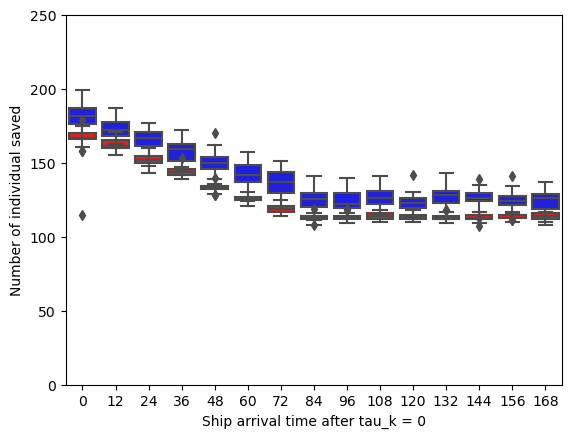

In [89]:
# Create a figure simiilar to Figure 3 in Rempel (2024)
ax = sns.boxplot(data = results_single, x = 'Ship arrival time', y = 'Objective', color = "red")
ax.set(ylabel = 'Number of individual saved', xlabel = 'Ship arrival time after tau_k = 0')
ax.set_ylim(bottom = 0, top = 250)

ax = sns.boxplot(data = results_multiple, x = 'Ship arrival time', y = 'Objective', color = "blue")
ax.set(ylabel = 'Number of individual saved', xlabel = 'Ship arrival time after tau_k = 0')
ax.set_ylim(bottom = 0, top = 250)

In [21]:
# create the environment and policy objects
env = MassEvacuation(initial_state = rempel_2024_initial_state, \
                     seed = rempel_2024_seed,
                     default_rng = False)

print(env.state)

# sample an action
action_sample = env.action_space.sample()

# convert the sampled action into an action that can be used by the environment
action = {'x_hl_k' : {'white' : action_sample['x_hl_k'][0,0], 
                      'green' : action_sample['x_hl_k'][0,1], 
                      'yellow' : action_sample['x_hl_k'][0,2], 
                      'red' : action_sample['x_hl_k'][0,3]}, \
          'x_sl_k' : {'white' : action_sample['x_sl_k'][0,0], 
                      'green' : action_sample['x_sl_k'][0,1], 
                      'yellow' : action_sample['x_sl_k'][0,2],
                      'red' : action_sample['x_sl_k'][0,3]},
          'x_su_k' : {'white' : action_sample['x_su_k'][0,0], 
                      'green' : action_sample['x_su_k'][0,1], 
                      'yellow' : action_sample['x_su_k'][0,2], 
                      'red' : action_sample['x_su_k'][0,3]}
                  }

print(action)

# submit the action to the environment and check what is returned
observation, reward, terminated, truncated, info = env.step(action)
print(observation)

{'tau_k': 0, 'e_k': 0, 'rho_e_k': {'white': 0, 'green': 475, 'yellow': 20, 'red': 5}, 'rho_s_k': {'white': 0, 'green': 0, 'yellow': 0, 'red': 0}}
{'x_hl_k': {'white': 6, 'green': 3, 'yellow': 10, 'red': 8}, 'x_sl_k': {'white': 12, 'green': 13, 'yellow': 20, 'red': 32}, 'x_su_k': {'white': 31, 'green': 17, 'yellow': 40, 'red': 48}}
{'tau_k': 48, 'rho_e_k': {'white': 0, 'green': 148, 'yellow': 37, 'red': 7}, 'rho_s_k': {'white': 0, 'green': 0, 'yellow': 0, 'red': 0}, 'e_k': 1}


array([[1, 2, 7, 3]], dtype=int32)

In [41]:
objective_value[10,:].mean()

123.53333333333333